# Pre-Operative Planning System for Neuromodulation Surgery for Spinal Cord Injury Rehabilitation

This project is about the automatic labeling for MRI to CT co-registration as part of the pre-operative computational pipeline for neuromodulation surgery for spinal cord injury rehabilitation.

***Authors: Ismail Benkirane & Sergio Hernandez***  
***Date: 14/12/2022***

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        Loading the needed functions
    </span>
</div>

All the needed function to run this notebook correctly are saved in a utils file. Please make sure that the file is located in the same folder as this main file. 

In [65]:
execfile('utils.py')

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        Aquiring Data
    </span>
</div>

Before loading the data, you have to make sure that all three files are RPI oriented. To check, you can run on the terminal : 

        sct_image -i 'img_path' -getorient
        
if the orientation is different, you can change the orientation of a file by running again on the terminal :

        sct_image -i 'img_path' -setorient 'RPI'
        
Also, MRI images need to be upsampled at the same size as CT images. Once you have the sampling size of the CT image (pixdim1xpixdim2xpixdim3), you can run the following line on the terminal to upsample the MRI data :

        sct_resample -i 'MRI_img_Path' -mm pixdim1xpicdim2xpixdim3

In [10]:
#Oriented images (RPI)
disks_seg_path = "/Users/ismail/switchdrive/PDS/folder/data/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Discs.nii.gz"
vert_seg_path_MRI = "/Users/ismail/switchdrive/PDS/folder/data/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Vertebrae.nii.gz"
vert_seg_path_CT = "/Users/ismail/switchdrive/PDS/folder/data/CT_Dicom_8.10_STIMO_20221101145337_302_seg_multi.nii.gz"

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        MRI Processing
    </span>
</div>

In this section, we will load the MRI image and the disks image. Using the disks information, we will segment the MRI image in order to separate the different vertebrae. In addition, we will compute the optimal volume for each vertebra.

### Loading the Vertebrae and Disk images
Using the function `load_image_np_data()` developed in the utils file, we load the disks and vertebrae images acquired using MRI. It returns basically the image in a numpy format.

In [11]:
img_vertebrae = load_image_np_data(vert_seg_path_MRI)
img_disks = load_image_np_data(disks_seg_path)

### Processing 

Now, using the loaded disk image, we will segment the MRI vertebrae image and store the optimal volume and the label of each vertebra. The `MRI_image_treatment()` function is implemented the following way:
- Separate the disks' data and group them into separate disks. This is done using `connected_components()` and `group_components()` functions that are defined in the utils file.
- Computes the location of the disk's centroids. The corresponding volume will be stored in the `all_vol_MRI` variable. This is done using the `find_centroids()` function that is defined in the utils file.
- Based on the disks separation, the function `vertebrae_seg()` will segment the MRI image into separate vertebrae. This function basically considers that there's a vertebra between two disks. So, by taking the maximum position of a disk, and the minimum position of the next one, we can "cut" the image in order to keep only one vertebra. This can be done for all vertebrae and lead to a segmented MRI image that will be stored in the `img_seg_MRI` variable. This function also label every vertebra. By considering that the one on the bottom of the image is the saccral vertebra, it goes upward and labels every one the vertebrae.
- Finally, the function `find_labels()` is called and will go through the values of all pixels in the image, and keep only the unique values and store them in a list by ordering them from the biggest to the smallest.

In [12]:
img_seg_MRI, all_vol_MRI, seg_labels_MRI = MRI_image_treatment(img_disks,img_vertebrae)  

### Visualization  

You can visualize the MRI images with the cell below :


 The vertebrae labels are:  [25 24 23 22 21 20 19 18 17 16 15 14]

 The corresponding volumes are:  [12, 13, 13, 13, 12, 13, 14, 14, 14, 13, 12, 12]

 Loaded disk segmentation image of shape :  (288, 768, 28)


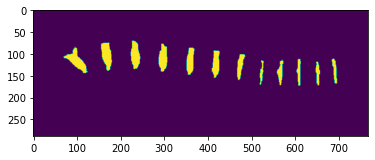


 Loaded vertebrae image of shape :  (288, 768, 28)


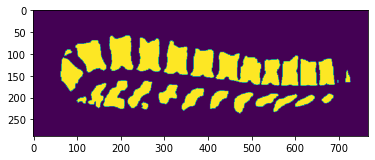

In [13]:
print("\n The vertebrae labels are: ", seg_labels_MRI)
print("\n The corresponding volumes are: ", all_vol_MRI)

print("\n Loaded disk segmentation image of shape : ", img_disks.shape)
plt.figure()
plt.imshow(img_disks[:,:,round(np.mean(all_vol_MRI))])
plt.show()
print("\n Loaded vertebrae image of shape : ", img_vertebrae.shape)
plt.figure()
plt.imshow(img_vertebrae[:,:,round(np.mean(all_vol_MRI))])
plt.show()

With the cell below, you can change the variable `vert_nb` and visualize each vertebra at a time. You can give this variable the values stored in the `seg_label_MRI` variable which in this case are going from 25 to 14.

Labeled vertebrae


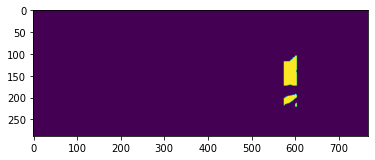

In [102]:
vert_nb = 16

img_vert_MRI = np.copy(img_seg_MRI)
img_vert_MRI[img_vert_MRI != vert_nb] = 0
    
print("Labeled vertebrae")
plt.figure()
plt.imshow(img_vert_MRI[:,:,all_vol_MRI[int(np.where(seg_labels_MRI==vert_nb)[0])]])
plt.show()

You can see on the image above that the segmentation isn't perfect. This is because of the method used for segmenting : Only using the disk data, we will have straight "cuts" in the image. However, vertebrae are often not straight, which is the reason why we have these results. In the scope of the study, this won't be an issue as we will be using only the upper part of each vertebra, which is perfectly accessible using this segmentation method.

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        CT processing
    </span>
</div>

In this section, the vertebrae image is already segmented as it is coming from a CT scan. Thus, we will load and store the vertebrae labels and compute the optimal volume for each one of them.

### Loading the vertebrae segmentation image

Using the function `load_image_np_data()` developed in the utils file, we load the CT scans images. It returns basically the image in a numpy format.

In [26]:
img_seg_CT = load_image_np_data(os.path.normpath(vert_seg_path_CT))

### Processing

Using the loaded segmented CT image, we extract the labels for each vertebra and compute their optimal volume. The `CT_image_treatment()` function is implemented the following way:
- Using the `find_label()` function, we compute and store the label of each vertebra
- Using the `find centroids()` function, we call the `group_target_components()` function to group the values of each vertebra together, and then compute the centroids to extract its corresponding volume.

In [27]:
seg_labels_CT, all_vol_CT = CT_image_treatment(img_seg_CT)

### Visualization 

You can visualize the CT image with the cell below :


 The vertebrae labels are:  [25 24 23 22 21 20 19 18 17 16 15 14]

 The corresponding volumes are:  [270, 261, 263, 264, 266, 268, 269, 271, 278, 281, 283, 285]

 Loaded vertebrae segmentation image of shape :  (512, 674, 512)


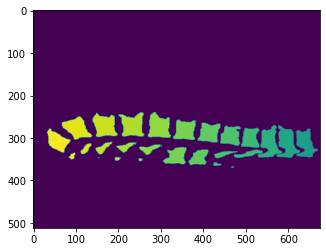

In [28]:
print("\n The vertebrae labels are: ", seg_labels_CT)
print("\n The corresponding volumes are: ", all_vol_CT)

print("\n Loaded vertebrae segmentation image of shape : ", img_seg_CT.shape)
plt.figure()
plt.imshow(img_seg_CT[:,:,round(np.mean(all_vol_CT))])
plt.show()

With the cell below, you can change the variable `vert_nb` and visualize each vertebra at a time. You can give this variable the values stored in the `seg_label_CT` variable which in this case are going from 25 to 14.

Labeled vertebrae


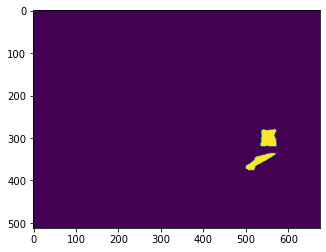

In [103]:
vert_nb = 16

img_vert_CT = np.copy(img_seg_CT)
img_vert_CT[img_vert_CT != vert_nb ] = 0

print("Labeled vertebrae")
plt.figure()
plt.imshow(img_vert_CT[:,:,all_vol_CT[int(np.where(seg_labels_CT==vert_nb)[0])]])
plt.show()

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        Labels computation
    </span>
</div>

In this section, the vertebrae that will be holding the labels are set. This selection depends on the region of interest, this is why we left the vertebrae variable available for change. In the cell below, you can initialize the variable `target` in the following way:
- `target = "hemon"` to use the vertebrae corresponding to the hemon study
- `target = "hemo"` to use the vertebrae corresponding to the hemo study
- `target = "stimo"` to use the vertebrae corresponding to the stimo study
- `target = "all"` to use all the available vertebrae

In [66]:
target = "hemon"

This cell will simply initialize the variable `vertebrae` that will contain the label of each selected vertebra.

In [67]:
vertebrae = []
if target == "hemon":
    vertebrae.append("L2")
    vertebrae.append("T12")
    vertebrae.append("T7")
elif target == "hemo":
    vertebrae.append("L5")
    vertebrae.append("L1")
    vertebrae.append("T7")
elif target == "stimo":
    vertebrae.append("L2")
    vertebrae.append("T10")
    vertebrae.append("T7")
elif target == "all":
    print("all vertebrae have been chosen")

In the next cell, a link is created between the real name of the vertebrae and their label stored in the label variables (`seg_labels_CT` & `seg_labels_MRI`). Here is a detailled explanation of the implementation of the function `label_selection` :
- First, as you may know, MRI and CT images could show a different number of vertebrae depending on the acquisition. So, we have to take the fewest number of vertebrae between the two images to be able to do the coregistration as it makes no sense to coregister a vertebra with another that does not exist. 
- After that, a dictionnary is created with the real name of the vertebrae as keys and their equivalent in numbers as values. 
- Then, by going through the vertebrae stored in the variable `vertebrae`, we will select only the right values from the dictionnary. 
- Finally, we will store the labels in the variable `label`, we will store the corresponding volumes of the MRI and CT respectively in the variables `volume_MRI` and `volume_CT`.

In [68]:
label, volume_MRI, volume_CT = label_selection(seg_labels_MRI, seg_labels_CT, all_vol_MRI, all_vol_CT, vertebrae)

The vertebrae accessible for this patient are: ['S1', 'L5', 'L4', 'L3', 'L2', 'L1', 'T12', 'T11', 'T10', 'T9', 'T8', 'T7']
The vertebrae used to position the label points are: ['L2', 'T12', 'T7']


Then, we compute N different images for each type of image aquisition corresponding to the N vertebrae used to position the labels. Basically, the `img_label()` function takes the segmented image, and put to 0 all the pixels that do not form the vertebra of interest.

In [69]:
label_MRI_img = img_label(img_seg_MRI, label)
label_CT_img = img_label(img_seg_CT, label)

### Visualization 

With the cell below, you can change the variable `vert` and visualize the same vertebra with the two types of data acquisition (MRI and CT). You can give this variable the values going from 0 to `len(label)-1`. For example, the images below correspond to the vertebra T7.


 MRI image corresponding to vertebra:  T7


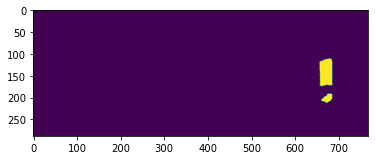


 CT image corresponding to vertebra:  T7


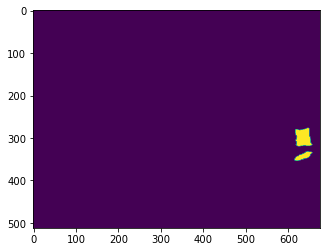

In [73]:
vert = 0
print("\n MRI image corresponding to vertebra: ", vertebrae[vert])
plt.figure()
plt.imshow(label_MRI_img[vert][:,:,volume_MRI[vert]])
plt.show()

print("\n CT image corresponding to vertebra: ", vertebrae[vert])
plt.figure()
plt.imshow(label_CT_img[vert][:,:,volume_CT[vert]])
plt.show()

</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        Preparing the output
    </span>
</div>

Here, using the images computed before, we will output 2 images with the same size as the input images, that will contain only few points that are non zero. These point are the label points

In [22]:
output_path = "/Users/ismail/switchdrive/PDS/folder"

Basically, the `final_image()` function puts all the pixels to 0, then put to 1 the pixel at the location of the label point to the vertebra's label. Then, the function `save_image_np_data()` saves the image as nifti file at output path location.

#### Saving the MRI image

In [23]:
img_final_MRI = final_image(img_seg_MRI, label_MRI_img, volume_MRI, label)
save_image_np_data(img_final_MRI, vert_seg_path_MRI, output_path, True)  

#### Saving the CT image

In [24]:
img_final_CT = final_image(img_seg_CT, label_CT_img, volume_CT, label)
save_image_np_data(img_final_CT, vert_seg_path_CT, output_path, False)

### Visualization 

Here's an example for the positionning of the label point with one vertebra. We chose to position it in the center of the upper curvature of the vertebrae as it is a point that do not change a lot between MRI and CT images. Furthermore, we tried with other positions, such as the upper right/left corner but no other positions gave better results than the one we are using.

Vertebra L2 with the label point positionned (in red)


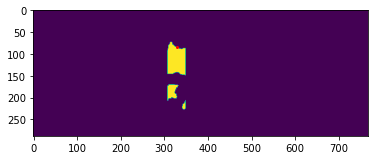

In [109]:
vert = 0
ref = ref_coord(label_MRI_img[vert],volume_MRI[vert])

print("Vertebra "+str(vertebrae[vert])+" with the label point positionned (in red)")
plt.figure()
plt.imshow(label_MRI_img[vert][:,:,volume_MRI[vert]])
plt.plot(ref[0], ref[1], "or", markersize=2)
plt.show()

### Verification 

This is a quick validation step to see if there are actually only N non-zero points, with N the number of vertebrae chosen to hold the label points. 

In [25]:
print("MRI image")
img_test = load_image_np_data('/Users/ismail/switchdrive/pds/test/MRI_labels.nii.gz')
print(np.where(img_test > 0))

print("CT image")
img_test = load_image_np_data('/Users/ismail/switchdrive/pds/test/CT_labels.nii.gz')
print(np.where(img_test > 0))

MRI image
(array([ 73,  79,  86, 100, 126, 150, 151, 166, 173, 188, 200]), array([115, 146,  86, 176, 204, 232,  61, 257, 280, 304, 324]), array([117, 121, 119, 128, 130, 132, 124, 135, 137, 140, 144]))
CT image
(array([ 73,  73,  82,  96,  98, 123, 143, 152, 179, 190, 204]), array([108, 139, 166,  79, 191, 218, 243, 265, 309,  64, 286]), array([256, 256, 257, 260, 259, 260, 259, 261, 266, 270, 264]))


</div>
<div class="00 Task" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black; font-size: 22px; font-weight: 600">
        **********************************************************************************************************
    </span>
</div>

### Terminal - Using the script

This notebook is also available as a script (main.py). In order to run the script directly from the terminal, you can run the following line while in the same folder as the python file : 

    python3 main.py -idisks /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Discs.nii.gz -imri /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Vertebrae.nii.gz -ict /Users/ismail/switchdrive/PDS/test/files3/postop/CT_Post_Op_Dicom_7.7_NEURORESTORE_20221122102834_303_seg_multi.nii.gz -o /Users/ismail/switchdrive/PDS/test/ -v 'hemon'
    
This is built according to the following structure: 

    main.py -idisks <input_disk_img> -imri <input_MRI_img> -ict <input_CT_img> -o <output_path> -v <vertebrae>
    
With:

    - <input_disk_img>: the path to the MRI disk image
    - <input_MRI_img> : the path to the MRI vertebrae image
    - <input_CT_img>  : the path to the CT vertebrae image
    - <output_path>   : the output path for the two output files
    - <vertebrae>   : Desired labelled vertebrae (Separated by a blank space) : 'X' 'Y' or directly the name of the study such as 'hemo', 'hemon', 'stimo'
    

### Terminal - Coregistration + Fsleyes

Once the two output path computed, directly from the terminal, in the same folder as these two files, we can run the following lines to do the coregistration and visualize the result :

    chmod u+x 02_co_registration_function_determination.sh

    ./02_co_registration_function_determination.sh /Users/ismail/switchdrive/PDS/test/files3/postop/CT_Post_Op_Dicom_7.7_NEURORESTORE_20221122102834_303.nii.gz /Users/ismail/switchdrive/PDS/test/files3/postop/CT_Post_Op_Dicom_7.7_NEURORESTORE_20221122102834_303_seg_bin.nii.gz /Users/ismail/switchdrive/PDS/test/Separate/S1/CT_labels.nii.gz /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9.nii.gz /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Vertebrae.nii.gz /Users/ismail/switchdrive/PDS/test/Separate/S1/MRI_labels.nii.gz /Users/ismail/switchdrive/PDS/test/coreg

    chmod u+x 03_applying_co_registration_function.sh

    ./03_applying_co_registration_function.sh /Users/ismail/switchdrive/PDS/test/files3/postop/CT_Post_Op_Dicom_7.7_NEURORESTORE_20221122102834_303_elec_seg.nii.gz /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9.nii.gz /Users/ismail/switchdrive/PDS/test/coreg/CT2MRI.nii.gz /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg.nii.gz
    
    chmod u+x 04_run_cleaning_seg_post_co_registration.sh
    
    ./04_run_cleaning_seg_post_co_registration.sh /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg.nii.gz /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg_cleaned.nii.gz 
    
        ./03_applying_co_registration_function.sh /Users/ismail/switchdrive/PDS/test/files3/postop/RieserCTpreOp_7.7_NEURORESTORE_20221102131239_301_seg_multi.nii.gz /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9.nii.gz /Users/ismail/switchdrive/PDS/test/coreg/CT2MRI.nii.gz /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg_multi.nii.gz
    
    chmod u+x 05_run_cleaning_seg_non_binary.sh 
    
    ./05_run_cleaning_seg_non_binary.sh  /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg_multi.nii.gz.nii.gz /Users/ismail/switchdrive/PDS/test/coreg
    
    fsleyes /Users/ismail/switchdrive/PDS/test/coreg/P03_CT_preop_seg_bin_reg.nii.gz /Users/ismail/switchdrive/PDS/test/files3/MRI_Dicom_t2_gre_sag_sergio_mat384_TR428_0.6x0.6_5min47_20221101132010_9_seg_Vertebrae.nii.gz